In [18]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 7)
init_notebook_mode(connected=True)
colors = {
    'ndk_float': '#00C677',
    'ndk_short': '#008894',
    'jvm_float': '#CB43E1',
    'jvm_short': '#556DFF',

    'ndk_complex': '#00C677',
    'ndk_real': '#008894',
    'jvm_complex': '#CB43E1',
    'jvm_real': '#556DFF'
}
sns.set_palette(sns.color_palette(colors.values()))

convolution = pd.read_csv('data/convolution_benchmark_1565338975946.csv', index_col='env')
fft = pd.read_csv('data/fft_benchmark_1565338975946.csv', index_col='env')

# Convolution (FIR filter)

FIR filter was implemented from scratch. Kotlin implementation: 

```kotlin
class FIRFloat(private val coefs: FloatArray) {
    private val length: Int = coefs.size
    private val delayLine: FloatArray
    private var count = 0

    init {
        delayLine = FloatArray(length)
    }

    fun getOutputSample(inputSample: Float): Float {
        delayLine[count] = inputSample
        var result = 0.0F
        var index = count
        for (i in 0 until length) {
            result += coefs[i] * delayLine[index--]
            if (index < 0) index = length - 1
        }
        if (++count >= length) count = 0
        return result
    }
}
```

C++ implementation is analogous.

In [68]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = convolution.T.index,
            y = convolution.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_float', 'jvm_short', 'ndk_float', 'ndk_short']
    ],
    'layout': go.Layout(title='Convolution full benchmark results', xaxis=dict(title='filter length'), yaxis=dict(title='samples / s'))
})

In [19]:
floats = convolution.T['jvm_float'] / convolution.T['ndk_float']
shorts = convolution.T['jvm_short'] / convolution.T['ndk_short']

In [20]:
floats.describe()

count    100.000000
mean       4.401738
std        0.865064
min        2.000000
25%        3.763517
50%        3.874317
75%        5.087633
max        6.000000
dtype: float64

In [21]:
shorts.describe()

count    100.000000
mean       5.038306
std        1.412922
min        2.600000
25%        4.244468
50%        4.310612
75%        5.363388
max        8.439998
dtype: float64

''

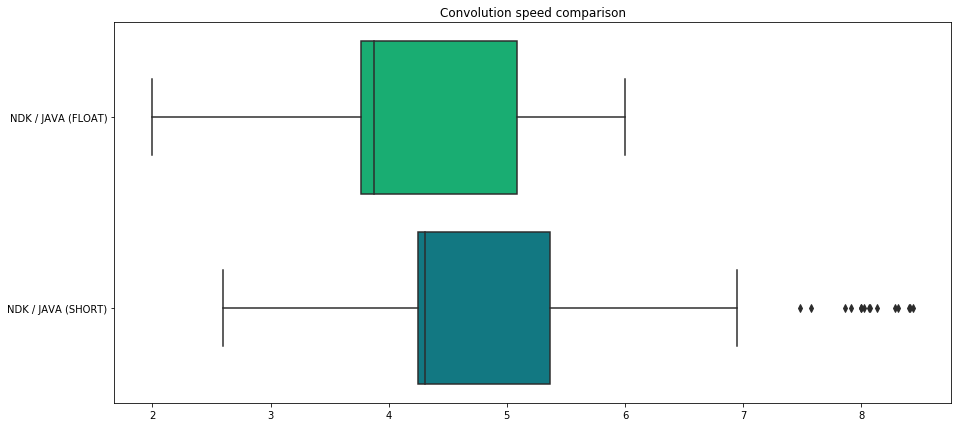

In [22]:
y = ['NDK / JAVA (FLOAT)'] * len(floats) + ['NDK / JAVA (SHORT)'] * len(shorts)
sns.boxplot(
    x=pd.concat([floats, shorts]),
    y=y
).set_title('Convolution speed comparison')
''

## Summary

For some reason JVM implementation was much faster. On average floats JVM implementation was ~4 times faster than NDK. JVM implementation using shorts was ~5 times faster than C++ shorts implementation.

# FFT

JVM version uses [JTransforms](https://github.com/wendykierp/JTransforms) library.
NDK version uses [FFTW](http://www.fftw.org/) library.

In [26]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = fft.T.index,
            y = fft.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_complex', 'jvm_real', 'ndk_complex', 'ndk_real']
    ],
    'layout': go.Layout(title='FFT full benchmark results', xaxis=dict(title='FFT width'), yaxis=dict(title='FFTs / s'))
})

In [27]:
complex = fft.T['ndk_complex'] / fft.T['jvm_complex']
real = fft.T['ndk_real'] / fft.T['jvm_real']
y = ['NDK / JAVA (COMPLEX)'] * len(complex) + ['NDK / JAVA (REAL)'] * len(real)

In [28]:
complex.describe()

count    50.000000
mean      2.656400
std       3.035800
min       1.000000
25%       1.515264
50%       1.757647
75%       1.984718
max      16.868590
dtype: float64

In [29]:
real.describe()

count    50.000000
mean      2.875981
std       2.945352
min       1.395349
25%       1.838573
50%       1.946407
75%       2.346068
max      17.638095
dtype: float64

''

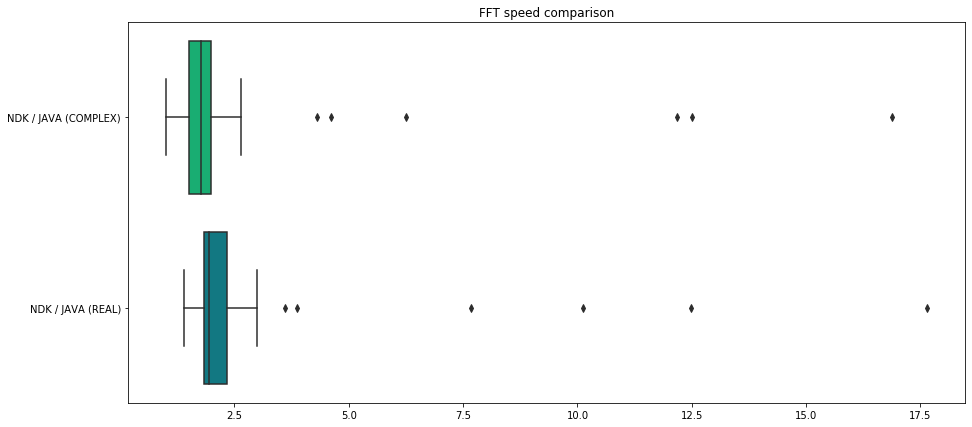

In [30]:
sns.boxplot(
    x=pd.concat([complex, real]),
    y=y
).set_title('FFT speed comparison')
''

## Summary

NDK implementation using complex numbers was on average 2.7 times faster than analogous implementation on JVM. On real numbers NDK implementation is ~2.9 times faster. Long right tail means there's a few outliers where NDK implementation was over 10 times faster.